<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250730/%E3%82%AA%E3%83%AA%E3%82%A8%E3%83%B3%E3%83%86%E3%83%BC%E3%83%AA%E3%83%B3%E3%82%B0%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#準備

In [ ]:
%%capture
# インストール
!pip install mip
!pip install japanize-matplotlib

#オリエンテーリング問題

この講義では数理計画法における経路最適化問題の一つである**オリエンテーリング問題 (Orienteering Problem - OP)** について学びます。
この問題は、指定されたスタート地点から制限時間（または総移動距離）内に、できるだけ多くの「スコア」を獲得しながらいくつかの地点を訪問し、指定されたゴール地点に到達するような最適な経路を見つけるものです。

##問題の概要

オリエンテーリング問題は、訪問することで得られるスコア（または「賞金」）が設定された地点群の中から、どの地点をどのような順序で訪問するかを決定する問題です。最大の特徴は、全ての地点を訪問する必要はなく、むしろ総移動時間または総移動距離に上限（予算）が設けられている点です。この予算内で、獲得スコアの合計を最大化する経路を選択します。

**問題の主要な要素:**
* **ノード (Nodes):** 地点の集合。これには、必須の**スタートノード**と**エンドノード**、そして訪問することでスコアが得られる複数の**スコア地点（またはコントロールポイント）**が含まれます。スタートとエンドは同じノードである場合もあります。
* **移動コスト ($t_{ij}$):** ノード $i$ からノード $j$ へ移動するのにかかる時間または距離。
* **スコア ($p_i$):** スコア地点 $i$ を訪問することで得られるスコア（賞金）。通常、スタートノードとエンドノードのスコアは0か、考慮外とされます。
* **総移動時間（距離）上限 ($T_{max}$):** スタートからエンドまでの経路全体の総移動時間（または総距離）が超えてはならない上限値。

**目的:** 総移動時間（距離）が上限 $T_{max}$ を超えないという制約の下で、訪問したスコア地点から得られるスコアの合計を最大化する経路（立ち寄る地点の選択とその順序）を見つけることです。

オリエンテーリング問題は、巡回セールスマン問題(TSP)や最短経路問題の要素を組み合わせ、さらにリソース制約（時間や距離の予算）と報酬獲得の要素を加えた、より複雑な問題と言えます。NP困難な問題に分類されます。

**実社会での応用例:**
* **観光ルート計画:** 限られた時間内で、できるだけ多くの観光名所（各名所に魅力度スコアがある）を巡る満足度の高いルートを作成する。
* **物流・配送計画:** 複数の配送先があり、全てを回る必要はないが、配送することで利益が得られる場合に、限られた稼働時間や走行距離の中で利益を最大化する配送ルートを決定する。
* **ロボットの経路計画:** 探査ロボットが制限されたバッテリー容量内で、できるだけ多くの価値あるサンプルを収集するための経路を計画する。
* **情報収集:** 限られた時間的・金銭的コストの中で、できるだけ価値の高い情報を複数の情報源から収集するための順序を決定する。

このノートブックでは、整数計画法を用いたオリエンテーリング問題の厳密解法を紹介します。特に、時間（または距離）の累積を追跡し、部分巡回路も除去できるような制約を用いた定式化（MTZ法に類似したアプローチ）を見ていきます。



---
## 定式化の詳細

ここでは、具体的な例題を通してオリエンテーリング問題の定式化を行います。

### 問題設定の例

ある旅行者が、スタート地点（ノード0）から出発し、制限時間 $T_{max}$ 内にいくつかの観光地（ノード1, 2）を巡り、最終的にゴール地点（ノード3）に到達する計画を立てています。各観光地には訪問することで得られるスコアがあります。

* **ノード:**
    * ノード0: スタート地点, 座標(0,0), スコア $p_0=0$
    * ノード1: 観光地A, 座標(1,3), スコア $p_1=10$
    * ノード2: 観光地B, 座標(4,4), スコア $p_2=20$
    * ノード3: ゴール地点, 座標(5,1), スコア $p_3=0$
* **移動時間 ($t_{ij}$):** ノード間のユークリッド距離を移動時間とします。
* **総移動時間上限 ($T_{max}$):** 例えば、10単位時間。


## 問題設定と地点を図示する。

図のように地点を配置し、地点間の距離はユークリッド距離を設定する。
また、移動距離の上限は9とする。
この場合、Spot A と Spot B の両方に行くことができない。
（両方に行く場合の距離は 3.162 + 3.162 + 3.162 = 9.486 となる。）


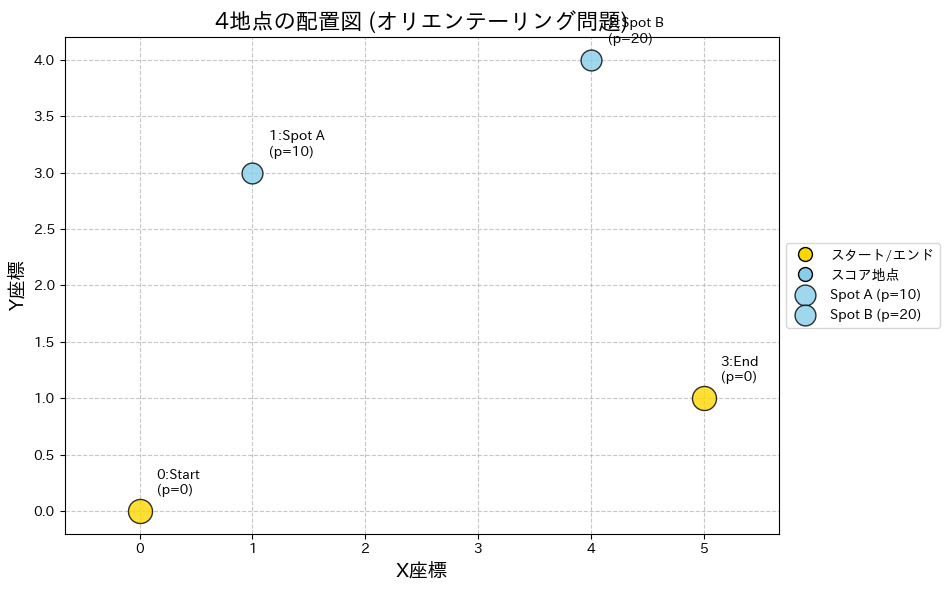

In [ ]:
#@title 地点の図示
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np
import math
import pandas as pd # DataFrame表示用

# 地点データ
nodes_coords = {
    0: {'name': 'Start', 'coords': (0, 0), 'prize': 0, 'type': 'StartEnd'},
    1: {'name': 'Spot A', 'coords': (1, 3), 'prize': 10, 'type': 'Prize'},
    2: {'name': 'Spot B', 'coords': (4, 4), 'prize': 20, 'type': 'Prize'},
    3: {'name': 'End',   'coords': (5, 1), 'prize': 0, 'type': 'StartEnd'}
}
node_indices = list(nodes_coords.keys())
num_nodes = len(node_indices)

# 移動時間行列の計算 (ユークリッド距離)
travel_times = {} # (i,j) -> time
for i in node_indices:
    for j in node_indices:
        if i == j:
            continue # 自分自身への移動時間は0または考慮外
        coord1 = nodes_coords[i]['coords']
        coord2 = nodes_coords[j]['coords']
        travel_times[i,j] = math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

#print("地点の座標とスコア:")
#for i, data in nodes_coords.items():
#    print(f"ノード {i} ({data['name']}): 座標{data['coords']}, スコア {data['prize']}")

#print("\n移動時間行列 (t_ij):")
time_matrix_df_data = np.full((num_nodes, num_nodes), np.nan)
node_map = {name: i for i, name in enumerate(node_indices)} # ノード名をインデックスに変換
for (orig, dest), time in travel_times.items():
    time_matrix_df_data[node_map[orig], node_map[dest]] = time
time_df = pd.DataFrame(time_matrix_df_data, index=[nodes_coords[i]['name'] for i in node_indices], columns=[nodes_coords[i]['name'] for i in node_indices])
#print(time_df.round(3))

# 地点の配置をプロット
plt.figure(figsize=(12, 6))
node_colors = {'StartEnd': 'gold', 'Prize': 'skyblue'}
node_sizes = {'StartEnd': 200, 'Prize': 150}

for i, data in nodes_coords.items():
    plt.scatter(data['coords'][0], data['coords'][1], marker='o',
                s=node_sizes[data['type']]*1.5, label=f"{data['name']} (p={data['prize']})" if data['type']=='Prize' else data['name'],
                color=node_colors[data['type']], edgecolors='black', zorder=5, alpha=0.8)
    plt.text(data['coords'][0] + 0.15, data['coords'][1] + 0.15, f"{i}:{data['name']}\n(p={data['prize']})", fontsize=10)

plt.xlabel("X座標", fontsize=14)
plt.ylabel("Y座標", fontsize=14)
plt.title(f"{num_nodes}地点の配置図 (オリエンテーリング問題)", fontsize=16)

# 凡例を整理
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # 重複を削除
# タイプごとの凡例を手動で追加
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='スタート/エンド', markerfacecolor='gold', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='スコア地点', markerfacecolor='skyblue', markersize=10, markeredgecolor='black')
]
unique_labels_from_plot = {label: handle for label, handle in by_label.items() if "Spot" in label} # スコア地点の凡例のみ抽出
plt.legend(handles=legend_elements + list(unique_labels_from_plot.values()), labels=[h.get_label() for h in legend_elements] + list(unique_labels_from_plot.keys()), loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.tight_layout(rect=[0,0,0.8,1]) # 凡例スペース確保
plt.show()

### 決定変数

オリエンテーリング問題を整数計画問題として定式化するために、以下の変数を定義します。
* $x_{ij} \in \{0, 1\}$: 経路がノード $i$ からノード $j$ へ直接移動する場合に1、そうでない場合は0となるバイナリ変数。
* $y_i \in \{0, 1\}$: スコア地点 $i$ を訪問しスコアを獲得する場合は1、しない場合は 0 となるバイナリ変数。($y_i$ はスコアのある地点に対して定義される)。
* $u_i$: ノード $i$ に到着する際の累積時間（または距離）。部分巡回路除去と時間予算管理を兼ねる。$u_{start}=0$ とする。

### 目的関数

訪問したスコア地点から得られる総スコアを最大化します。
$$\text{Maximize} \quad Z = \sum_{i \in \text{スコア地点}} p_i y_i$$
ここで、$p_i$ はスコア地点 $i$ を訪問することで得られるスコアです。

#### 制約条件

$V$ を全ノードの集合、$V_P \subseteq V$ をスコア地点の集合、$s \in V$ をスタートノード、$e \in V$ をエンドノードとします。

1.  **経路の開始と終了:**
    * スタートノード $s$ からは必ず1つの経路が出発します:
        $$\sum_{j \in V, j \neq s} x_{sj} = 1$$
    * エンドノード $e$ へは必ず1つの経路が到着します:
        $$\sum_{i \in V, i \neq e} x_{ie} = 1$$

2.  **スコア地点のフロー保存と訪問決定:**
    * 各スコア地点 $k \in V_P$ について、もし訪問するなら($y_k=1$)、入ってくるアークと出ていくアークがそれぞれ1本ずつ存在します。訪問しないなら($y_k=0$)、フローの出入りはありません。
        $$\sum_{i \in V, i \neq k} x_{ik} = y_k \quad \forall k \in V_P$$       $$\sum_{j \in V, j \neq k} x_{kj} = y_k \quad \forall k \in V_P$$

3.  **累積時間（距離）と部分巡回路除去 (MTZ類似):**
    * スタートノード $s$ での累積時間は0であり、$u_s = 0$ とする。
    * スタートノード以外では、以下の制約条件を考える。
        $$u_j \ge u_i + t_{ij} - M(1 - x_{ij}) \quad \forall (i,j) \text{ s.t. } j \neq s$$
        ここで $M$ は十分に大きな正の定数（例えば $T_{max} + \max(t_{ij})$ など）とする。

         上の制約条件は、アーク $(i,j)$ が経路で使用される場合 ($x_{ij}=1$)では
        $$u_j \ge u_i + t_{ij}
        $$
        となり、ノード $j$ への到着時間 $u_j$ は、$i$ への到着時間 $u_i$ と移動時間 $t_{ij}$ の和以上となることを要求する。
        また、$x_{ij}=0$ならば、
        $$u_j \ge u_i + t_{ij} - M
        $$        
        となり、冗長な制約となる。
        
        これは部分巡回路も除去する。

    * 各スコア地点 $i \in V_P$ での累積時間 $u_i$ は、その地点を訪問する場合 ($y_i=1$) にのみ意味を持ち、予算 $T_{max}$ を超えられません。
        $$u_i \le T_{max} \cdot y_i \quad \forall i \in V_P$$

4.  **総移動時間（距離）上限:**
    エンドノード $e$ への到着時間が、総移動時間の上限 $T_{max}$ を超えてはなりません。
    $$u_e \le T_{max}$$

5.  **変数型制約:**
$$x_{ij} \in \{0, 1\} \quad \forall i,j \in V, i \neq j$$   $$y_i \in \{0, 1\} \quad \forall i \in V_P$$   $$0 \le u_i \le T_{max} \quad \forall i \in V$$

---
### 数理モデル（数式表記）

上記をまとめると、オリエンテーリング問題の数理モデルの一例は以下のようになります。
（$V_0 = V \setminus \{s\}$ とする）

**集合とパラメータ:**
* $V$: 全ノード（地点）の集合 $\{s, e, v_1, v_2, \ldots \}$
* $V_P \subseteq V \setminus \{s,e\}$: スコア地点の集合
* $s$: スタートノード
* $e$: エンドノード
* $p_k$: スコア地点 $k \in V_P$ のスコア
* $t_{ij}$: ノード $i$ からノード $j$ への移動時間（または距離）
* $T_{max}$: 総移動時間（または距離）の上限
* $M$: 十分に大きな正の定数

**決定変数:**
* $x_{ij} \in \{0,1\}$: アーク $(i,j)$ を経路で使用するなら1、しないなら0
* $y_k \in \{0,1\}$: スコア地点 $k \in V_P$ を訪問するなら1、しないなら0
* $u_i \ge 0$: ノード $i \in V$ に到着する際の累積時間（または距離）

**目的関数:**
$$\text{Maximize} \quad \sum_{k \in V_P} p_k y_k$$

**制約条件:**
$$\sum_{j \in V, j \neq s} x_{sj} = 1 \quad \text{(スタートノードから出発)}$$

$$\sum_{i \in V, i \neq e} x_{ie} = 1 \quad \text{(エンドノードへ到着)}$$

$$\sum_{i \in V, i \neq k} x_{ik} = y_k \quad \forall k \in V_P \quad \text{(スコア地点訪問と経路の連結)}$$

$$u_s = 0 \quad \text{(スタート時刻)}$$

$$u_j \ge u_i + t_{ij} - M(1 - x_{ij}) \quad \forall (i,j) \text{ s.t. } i,j \in V, i \neq j, j \neq s \quad \text{(時間累積と部分巡回路除去)}$$

$$u_i \le T_{max} \cdot y_i\quad \forall i \in V_p \quad \text{(各地点到着時刻は予算内)}$$

$$u_e \le T_{max} \quad \text{(最終到着時刻は予算内、上記に含まれるが明示)}$$

$$x_{ij} \in \{0,1\}, y_k \in \{0,1\}, u_i \ge 0$$


##Python MIP を用いた実装例

それでは、先ほどの4地点の例題を `python-mip` を用いて解いてみましょう。
（$T_{max}=9$ とします）

In [ ]:
from mip import Model, xsum, maximize, BINARY, CONTINUOUS, OptimizationStatus
import math
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd

# --- データ定義 (問題設定の例から) ---
nodes_op_data = {
    0: {'name': 'Start', 'coords': (0, 0), 'prize': 0, 'type': 'Start'},
    1: {'name': 'Spot A', 'coords': (1, 3), 'prize': 10, 'type': 'Prize'},
    2: {'name': 'Spot B', 'coords': (4, 4), 'prize': 20, 'type': 'Prize'},
    3: {'name': 'End',   'coords': (5, 1), 'prize': 0, 'type': 'End'}
}
node_indices_op = list(nodes_op_data.keys())
num_nodes_op = len(node_indices_op)
start_node_op = 0
end_node_op = 3

prize_nodes_op = [i for i, data in nodes_op_data.items() if data['type'] == 'Prize']
prizes_op = {i: nodes_op_data[i]['prize'] for i in prize_nodes_op}

# 移動時間行列の計算
travel_times_op = {}
for i in node_indices_op:
    for j in node_indices_op:
        if i == j: continue
        coord1 = nodes_op_data[i]['coords']
        coord2 = nodes_op_data[j]['coords']
        travel_times_op[i,j] = math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

T_max = 9 #10.0 # 総移動時間上限
M_op = T_max + max(travel_times_op.values()) + 1 # MTZ制約用の大きな数

# --- モデル作成 ---
model_op = Model("OrienteeringProblem")

# 決定変数 x_ij: アーク(i,j)を使用するか
x = {(i, j): model_op.add_var(var_type=BINARY, name=f"x_{i}_{j}")
     for i in node_indices_op for j in node_indices_op if i != j}

# 決定変数 y_i: スコア地点iを訪問するか (スコア地点のみ)
y = {i: model_op.add_var(var_type=BINARY, name=f"y_{i}")
     for i in prize_nodes_op}

# 決定変数 u_i: ノードiへの到着時刻
u = {i: model_op.add_var(lb=0, ub=T_max, name=f"u_{i}") for i in node_indices_op}

# 目的関数: 獲得スコアの最大化
model_op.objective = maximize(xsum(prizes_op[i] * y[i] for i in prize_nodes_op))

# 制約条件
# 1. スタートノードから出発
model_op += xsum(x[start_node_op, j] for j in node_indices_op if j != start_node_op) == 1, "LeaveStart"
model_op += xsum(x[j, start_node_op] for j in node_indices_op if j != start_node_op) == 0, "NoEnterStart" # スタートへは戻らない

# 2. エンドノードへ到着
model_op += xsum(x[i, end_node_op] for i in node_indices_op if i != end_node_op) == 1, "EnterEnd"
model_op += xsum(x[end_node_op, i] for i in node_indices_op if i != end_node_op) == 0, "NoLeaveEnd" # エンドからは出ない

# 3. スコア地点のフロー保存と訪問決定
for k in prize_nodes_op:
    model_op += xsum(x[i, k] for i in node_indices_op if i != k) == y[k], f"FlowIn_{k}_eq_y_{k}"
    model_op += xsum(x[k, j] for j in node_indices_op if j != k) == y[k], f"FlowOut_{k}_eq_y_{k}"

# 4. 時間累積と部分巡回路除去
model_op += u[start_node_op] == 0, "StartTime" # スタート時刻は0

for i in node_indices_op:
    for j in node_indices_op:
        if i == j or j == start_node_op: continue # 自分自身へ、またはスタートへ戻るアークは時間制約の対象外
        if (i,j) in x: # x[i,j] が定義されているアークに対してのみ
             model_op += u[j] >= u[i] + travel_times_op[i,j] - M_op * (1 - x[i,j]), f"TimeSubtour_{i}_{j}"

# 5. (オプション) 訪問されるスコア地点のu_iに関する制約
# y_i=0 なら u_i=0 (または非常に小さい値) になるようにする。
# u_i は到着時刻なので、y_i=0 の場合はそのノードには到着しない。
# 上記の MTZ と T_max 上限で実質的に機能するが、明示的にyとuを関連付けるなら:
for i_node in prize_nodes_op:
     model_op += u[i_node] <= T_max * y[i_node], f"u_linked_to_y_{i_node}"


# モデルの最適化
status = model_op.optimize(max_seconds=120)

# --- 結果の表示 ---
optimal_path_op = []
total_prize_op = 0.0
total_time_op = 0.0

if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    total_prize_op = model_op.objective_value
    print(f"解が見つかりました。獲得総スコア: {total_prize_op:.2f}")

    visited_prize_nodes = [i for i in prize_nodes_op if y[i].x >= 0.99]
    print(f"訪問したスコア地点: {visited_prize_nodes}")

    # 経路の復元
    current_node = start_node_op
    optimal_path_op.append(current_node)
    path_time = 0

    # path reconstruction needs to handle non-visits
    # We look for x_ij = 1
    # Limit iterations to avoid infinite loops in case of issues
    for _ in range(num_nodes_op * num_nodes_op ): # Max possible edges in a path
        if current_node == end_node_op and len(optimal_path_op) > 1: # エンドノードに到達したら終了
            break
        found_next_in_path = False
        for j_node in node_indices_op:
            if j_node != current_node and (current_node, j_node) in x and x[current_node, j_node].x >= 0.99:
                # Check if this segment was truly part of the path to end_node_op
                # This simple reconstruction might pick up unused x_ij=1 if a node y_i=0
                # We need to ensure that if y_k=0, no x_ik or x_kj is 1 for that k.
                # The constraints y_k = sum(x_ik) and y_k = sum(x_kj) handle this.
                optimal_path_op.append(j_node)
                path_time += travel_times_op[current_node, j_node]
                current_node = j_node
                found_next_in_path = True
                break
        if not found_next_in_path and current_node != end_node_op:
            # This might happen if the problem is infeasible or solution is partial
            # print(f"経路復元注意: {current_node} から次のノードが見つかりません。")
            break

    total_time_op = u[end_node_op].x if u[end_node_op].x is not None else path_time # u[end_node]が最終時間
    print(f"経路: {optimal_path_op}")
    #print(f"総移動時間: {total_time_op:.3f} (上限: {T_max})")
    print("各地点の訪問時刻 (u_i):")
    for i_node in node_indices_op:
        is_on_path = False
        if i_node in optimal_path_op: # 実際に経路に含まれるか
            # y_i が0でもu_iが値を持つ場合があるため、y_iも考慮
            if i_node == start_node_op or i_node == end_node_op or (i_node in prize_nodes_op and y[i_node].x >=0.99):
                 is_on_path = True

        if is_on_path and u[i_node].x is not None and u[i_node].x > -1e-5 : # わずかに負になる場合を避ける
             print(f"  ノード {i_node} ({nodes_op_data[i_node]['name']}): 到着時刻 {u[i_node].x:.3f}")


elif status == OptimizationStatus.INFEASIBLE:
    print("実行不可能な問題です。制約を満たす解が存在しません。")
else:
    print(f"最適化が停止しました（時間切れまたは解なし）。ステータス: {status}")


解が見つかりました。獲得総スコア: 20.00
訪問したスコア地点: [2]
経路: [0, 2, 3]
各地点の訪問時刻 (u_i):
  ノード 0 (Start): 到着時刻 0.000
  ノード 2 (Spot B): 到着時刻 5.657
  ノード 3 (End): 到着時刻 9.000


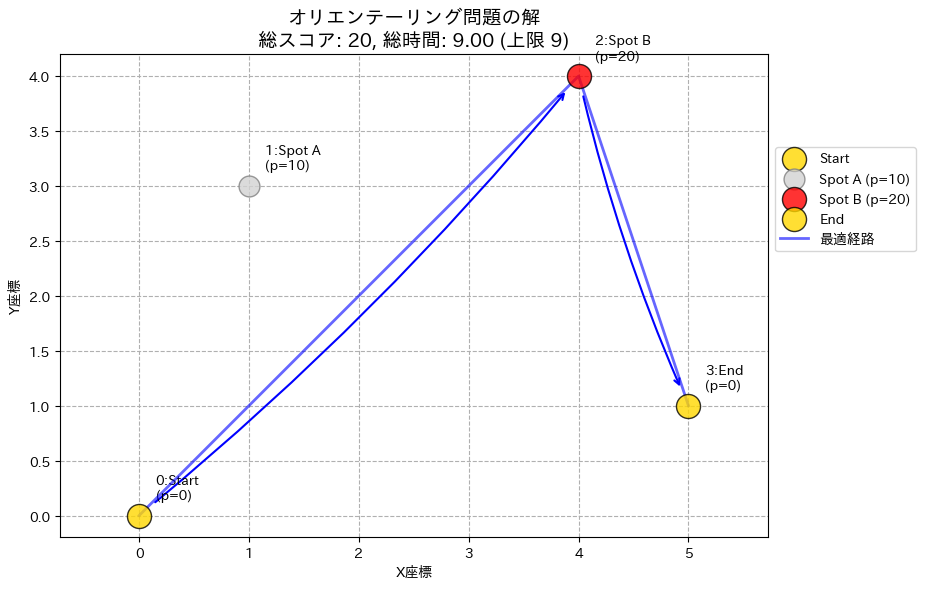

In [ ]:
#@title 結果の図示
# --- 結果の図示 ---
plt.figure(figsize=(12, 6))

for i_node_plot, data_plot in nodes_op_data.items():
    is_visited_prize = (data_plot['type'] == 'Prize' and i_node_plot in prize_nodes_op and y[i_node_plot].x >= 0.99)
    is_start_end = (data_plot['type'] == 'Start' or data_plot['type'] == 'End')

    node_color = 'red' if is_visited_prize else ('gold' if is_start_end else 'lightgray')
    node_s = 200 if is_visited_prize or is_start_end else 150
    edge_c = 'black' if is_visited_prize or is_start_end else 'grey'

    plt.scatter(data_plot['coords'][0], data_plot['coords'][1], marker='o', s=node_s*1.5,
                color=node_color, edgecolors=edge_c, zorder=5, alpha=0.8,
                label=f"{data_plot['name']} (p={data_plot['prize']})" if data_plot['type']=='Prize' else data_plot['name'])
    plt.text(data_plot['coords'][0] + 0.15, data_plot['coords'][1] + 0.15, f"{i_node_plot}:{data_plot['name']}\n(p={data_plot['prize']})", fontsize=10)

if optimal_path_op and len(optimal_path_op) > 1 :
    path_coords = np.array([nodes_op_data[node_idx]['coords'] for node_idx in optimal_path_op])
    plt.plot(path_coords[:,0], path_coords[:,1], 'b-', alpha=0.6, linewidth=2, markersize=5, zorder=3, label="最適経路")
    for k_path_idx in range(len(optimal_path_op) - 1):
        s_coords_path = nodes_op_data[optimal_path_op[k_path_idx]]['coords']
        e_coords_path = nodes_op_data[optimal_path_op[k_path_idx+1]]['coords']
        plt.annotate("", xy=e_coords_path, xytext=s_coords_path,
                     arrowprops=dict(arrowstyle="->", color="blue", lw=1.5, shrinkA=15, shrinkB=15, connectionstyle="arc3,rad=0.05"), zorder=2)
    plt.legend(loc='center left', bbox_to_anchor=(1,0.7))

plt.xlabel("X座標"); plt.ylabel("Y座標")
if total_prize_op > -1e5 : # 有効な解が得られた場合
    plt.title(f"オリエンテーリング問題の解\n総スコア: {total_prize_op:.0f}, 総時間: {total_time_op:.2f} (上限 {T_max})", fontsize=14)
else:
    plt.title(f"オリエンテーリング問題 (解の状態: {status})", fontsize=14)
plt.grid(True, linestyle='--'); plt.axis('equal')
plt.tight_layout(rect=[0,0,0.78,1])
plt.show()

#### 結果の解釈

上記のコードを実行すると、以下の情報が得られます。
* **獲得総スコア:** 最大化された目的関数の値。これが、時間予算内で獲得できた最大のスコア合計です。
* **訪問したスコア地点:** $y_i=1$ となったスコア地点のリスト。
* **経路:** スタートからエンドまでの訪問順序。
* **総移動時間:** 経路全体の実際の総移動時間。これは $T_{max}$ 以下であるはずです。
* **各地点の訪問時刻:** $u_i$ の値。経路上の各地点にいつ到着したかを示します。
* **結果の図示:** 地図上に全地点がプロットされ、最適解として得られた経路が線で結ばれ、訪問したスコア地点が強調表示されます。

この結果は、限られたリソース（時間や距離）の中で、どの地点を優先的に訪問し、どのような順序で巡るのが最も効果的かという戦略的な意思決定に役立ちます。

---
### モデルの改善に関する簡単な視点

オリエンテーリング問題もTSPと同様にNP困難であり、大規模なインスタンスの厳密解法は困難な場合があります。
* **より洗練された部分巡回路除去:** MTZ類似の制約は、ノード数が増えると弱くなることがあります。VRPなどで用いられるより強力な部分巡回路除去制約（例：動的な制約追加）も考えられますが、実装が複雑になります。
* **ヒューリスティクス:** 大規模問題や実時間性が求められる場合、近似解法が重要です。挿入法、局所探索、メタヒューリスティクス（遺伝的アルゴリズム、焼きなまし法など）が研究されています。
* **バリエーション:**
    * **チームオリエンテーリング問題 (Team Orienteering Problem - TOP):** 複数の経路（例：複数のセールスマンや車両）を用いて、全体の獲得スコアを最大化する。各経路は個別の時間予算を持つ。
    * **時間枠付きオリエンテーリング問題 (Orienteering Problem with Time Windows - OPTW):** 各スコア地点に訪問可能な時間枠が指定されている。
    * **確率的オリエンテーリング問題:** スコアや移動時間が不確実性を持つ場合。


---
#演習問題


##演習問題1

例題で、スコア地点1 (Spot A) のスコアを50に増加させた場合、
獲得スコアの最大値を求めよ。


##演習問題2

例題の設定に戻し、総移動時間の上限を10にした場合、獲得スコアの最大値を求めよ。

##演習問題3
例題の設定で、スコア地点1 (Spot A) を必ず訪問しなければならないという制約を追加した場合の獲得総スコアの最大値を求めなさい。


##演習問題4
**問題:**
基本例のスタート地点0とエンド地点3は共通としますが、2つの独立した経路 (2人の旅行者、または2台の車両) でスコア地点を分担して訪問できるとします。各経路の総移動時間上限はそれぞれ $T_{max}=9$ です。スコア地点は一度訪問されればスコアが得られ、複数の経路で同じスコア地点を訪問してもスコアは重複して加算されません。全体の獲得総スコアの最大値を求めなさい。

**考え方:**
1.  経路ごとに決定変数 $x^p_{ij}$ (経路pがアーク$(i,j)$を使用),
 $u^p_i$ (経路pでのiへの到着時間) を定義します。
2.  スコア地点 $k$ がいずれかの経路で訪問されればスコア獲得とみなすため、$y_k$ (スコア地点kが訪問されるか) を定義し、制約条件
$$
        \sum_{p \in P} \sum_{i \in V, i \ne k} x_{ik}^p = y_k \quad \forall k \in V_P
$$
を設けます。
3.  各経路 $p$ について、時間上限 $T_{max}$ を守る制約を課します。
4.  目的関数は $\sum_k p_k y_k$ の最大化。

としてモデル化を行う。


##演習問題5

**問題:**
基本例において、スコア地点1 (Spot A) は累積時間 $[2, 5]$ の間に、スコア地点2 (Spot B) は累積時間 $[4, 9]$ の間に訪問しなければならないという時間枠制約を追加します。訪問しない場合はこの制約は関係ありません。この条件下で最適な経路、獲得総スコア、総移動時間を求めなさい。


**指示:**
基本例のモデルの累積時間変数 $u_i$ に対し、
$$
L_k y_k \le u_k \le U_k y_k + M \cdot (1 - y_k) \quad \forall k \in V_{TW}
$$
という形の制約を追加します。ここで $L_k, U_k$ はそれぞれスコア地点 $k$ の訪問可能開始時刻と終了時刻、$M$ は大きな数です。
